<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Мы имеем исторические данные о заказах такси в аэропортах.
Нам необходимо спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.


- Значение метрики **RMSE** на тестовой выборке должно быть не больше **48**
- Количество заказов находится в столбце **'num_orders' (от англ. number of orders, «число заказов»)**

# Подготовка

In [1]:
#импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os

!pip install plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2
import requests
!pip install cufflinks
import cufflinks as cf
cf.go_offline()
cf.set_config_file(world_readable=True, theme='pearl', offline=True)



#стат блок
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

!pip install prophet
from prophet import Prophet

#настройки
pd.set_option("display.max_rows", 10000)
pd.set_option('max_colwidth', 10000)
pd.set_option('display.width', 500)
pd.set_option("display.float_format", "{:,.2f}".format)
sns.set(style="whitegrid", palette="Pastel1")


import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import (
                ElasticNet,
                Ridge,
                Lasso
)
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import (
                Pipeline, 
                make_pipeline
)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import ( 
                TimeSeriesSplit,
                train_test_split,
                GridSearchCV,
                cross_val_score
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)


RANDOM_STATE = 42

C:\Users\390\anaconda3\envs\ds_practicum_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    taxi = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
except FileNotFoundError:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
#оставим копию на всякий случай
try:
    df = pd.read_csv('taxi.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
taxi.columns

Index(['num_orders'], dtype='object')

In [5]:
#функция для быстрого просмотра данных
def information(df: 'DataFrame', name: 'str') -> None:
    print('*'*30,name,'*'*30)
    print()
    display(df.head(3))
    print('-'*25,'INFO','-'*25)
    print()
    display(df.info())
    print()
    print('-'*10,'NAN','-'*10)
    print()
    display(df.isna().sum())
    display(pd.DataFrame(round(df.isna().mean()*100,1)).sort_values(by=0, ascending=False).style.background_gradient('coolwarm'))
    print()
    print('-'*5,'DESCRIBE','-'*5)
    display(df.describe())
    print()
    print('-'*5,'DUPLICATED','-'*5)
    display(df.duplicated().sum())
    print()
    print('-'*25,'UNIQUE VALUES','-'*25)
    for column in df.columns:
        display(column)
        display(len(df[column].unique()))
        print('+'*25)
    print("-"*100)

In [6]:
information(taxi, 'Такси')

****************************** Такси ******************************



num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28

------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


---------- NAN ----------



num_orders    0
dtype: int64


----- DESCRIBE -----


num_orders
count   26,496.00
mean        14.07
std          9.21
min          0.00
25%          8.00
50%         13.00
75%         19.00
max        119.00


----- DUPLICATED -----


26415


------------------------- UNIQUE VALUES -------------------------


'num_orders'

81

+++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------


### Вывод:

Итак, данные выгружены:
- Выполнили чтение файла с разпознованием даты, дату поставили в индекс
- Мы имеем **26496** наблюдений
- В **datetime** имеем интервалы в **10 минут**
- Максимальное количество заказов **119** скорее всего выбросы, нужно исследовать наш таргет


# Анализ

Проверим, все ли индексы у нас уникальны.

In [7]:
print('Все индексы уникальны -', taxi.index.is_unique)

Все индексы уникальны - True


In [8]:
taxi.shape[0]

26496

Проверим последовательность индексов.

In [9]:
print('Индексы отсортированы в порядке возрастания -', taxi.index.is_monotonic)

Индексы отсортированы в порядке возрастания - True


In [10]:
#делаем ресэмплинг по 1 часу
taxi = taxi.resample('1H').sum()

In [11]:
taxi.shape[0]

4416

In [12]:
display(taxi.index.max())
display(taxi.index.min())

Timestamp('2018-08-31 23:00:00', freq='H')

Timestamp('2018-03-01 00:00:00', freq='H')

Наблюдения у нас с **1 марта 2018 года по 31 августа 2018 года**

In [13]:
taxi.index.max() - taxi.index.min()

Timedelta('183 days 23:00:00')

Всего **183** дня наблюдений, наблюдения производились с 00:00:00 по  23:00:00

**Посмотрим интерактивный график заказов по нашему датасету**

In [14]:
#функция для просмотра интерактивного графика по датасету
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
%pylab inline    
 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [15]:
plotly_df(taxi, title='Число заказов')
plt.show('svg')

Посмотрим на распределение нашего таргета:

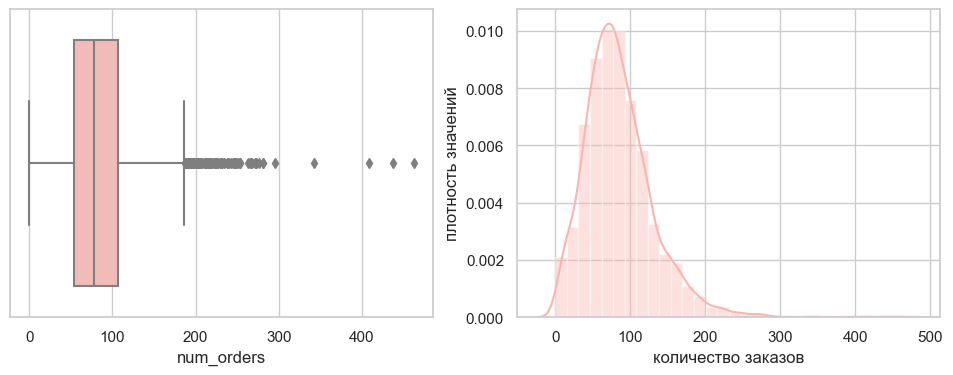

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(taxi['num_orders'], ax=axs[0])
sns.distplot(taxi['num_orders'], ax=axs[1], bins=30, rug=False)
plt.ylabel('плотность значений')
plt.xlabel('количество заказов');

In [17]:
taxi['num_orders'].quantile([0.0, 0.01, 0.02, 0.05, 0.1, 0.25, .5, .65, .75, .85, .93, .97, .99, 1]).transpose()

0.00     0.00
0.01     7.00
0.02    11.30
0.05    21.00
0.10    34.00
0.25    54.00
0.50    78.00
0.65    94.00
0.75   107.00
0.85   126.00
0.93   156.00
0.97   184.00
0.99   223.00
1.00   462.00
Name: num_orders, dtype: float64

По распределению значений можем наблюдать выбросы примерно после **184** заказов, но так как подробностей нам не узнать, будем исследовать данные. Видим, что частота значений начиная от **184** и заканчивая **290** заказами имеет плюс минус плотное распределение. Посмторим на цифры выше **300** особенно даты в эти заказы.

In [18]:
taxi.query('num_orders >=300')

num_orders
datetime                       
2018-08-13 02:00:00         437
2018-08-20 02:00:00         462
2018-08-27 02:00:00         408
2018-08-30 17:00:00         342

Интересно, что выбросы свыше **300** заказов были в основном в августе по понедельникам в **02:00**, вероятнее всего возвращающиеся с отпусков, так как в ночь с вскр на пнд, и один из дней четверг **30 августа** в час пик в **17:00**  это скорее всего суматоха родителей перед началом учебного года у школьников. Исходя иза этих данных можно сделать выводы, какие признаки создавать для модели: можно взять **день недели** и **время суток**

### Посмотрим на общую картину нашего временного ряда

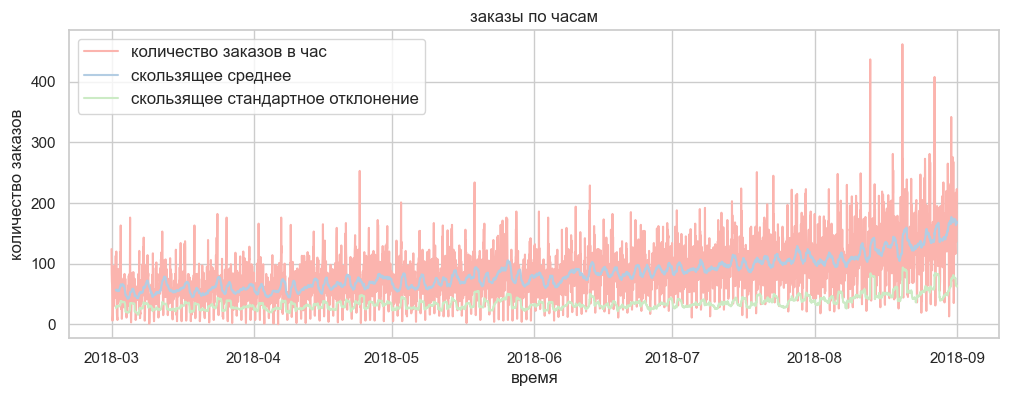

In [19]:
# построим график временного ряда
plt.figure(figsize=(12, 4))
plt.plot(taxi, label = 'количество заказов в час')
plt.plot(taxi.rolling(24).mean(), label = 'скользящее среднее')
plt.plot(taxi.rolling(24).std(), label = 'скользящее стандартное отклонение')

plt.legend(title='', loc='upper left', fontsize=12)
plt.xlabel('время')
plt.ylabel('количество заказов')
plt.title('заказы по часам')
plt.show;

- Как видим тренд на повышение идет с начала **апреля** и до конца наблюдений
- Видны переодичные всплески по месяцам, можно увидеть что в конце **апреля** есть большой всплеск, в **мае**, а также большее количество всплесков наблюдаем в **августе**

### Визуализируем данные по составляющим. Проанализируем их по последнему месяцу наблюдений - август 2018.

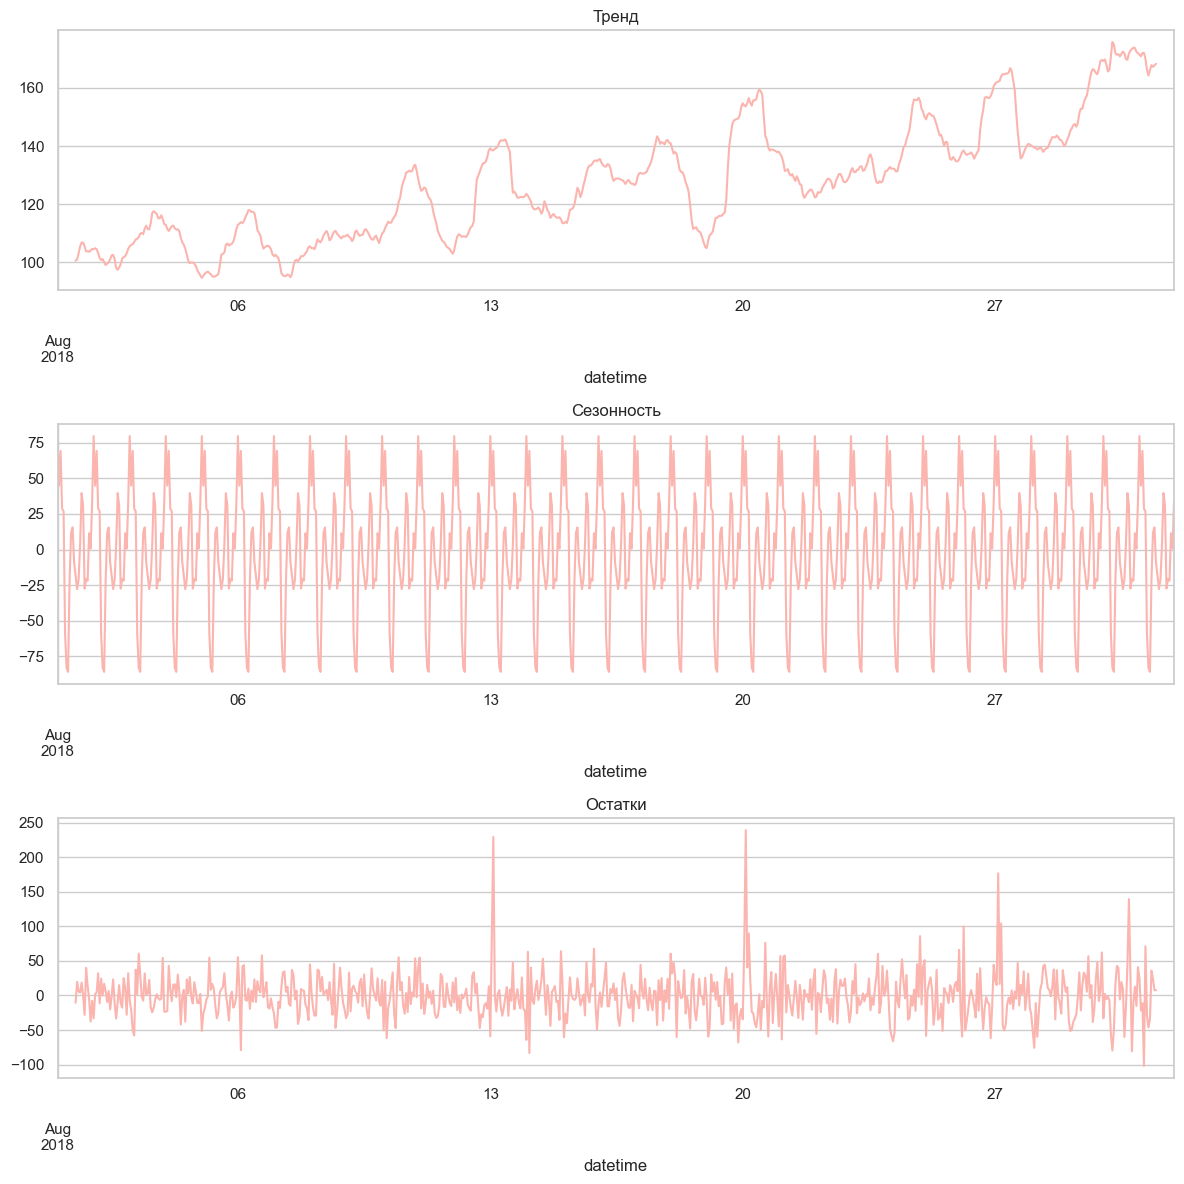

In [20]:
decomposed = seasonal_decompose(taxi['2018-08-01':'2018-08-31'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

- Тренд имеет рост на протяжении всего месяца, очень хорошо видно наши пики - **13, 20, 27 и 30 августа**
- Чтобы понять как влияет сезонность нужно сделать визуализацию автокорреляции
- Остатки тоже имеют переодические всплески как раз в те же дни что и у тренда

### Посмотрим на сезонность и тренд по всему датасету 

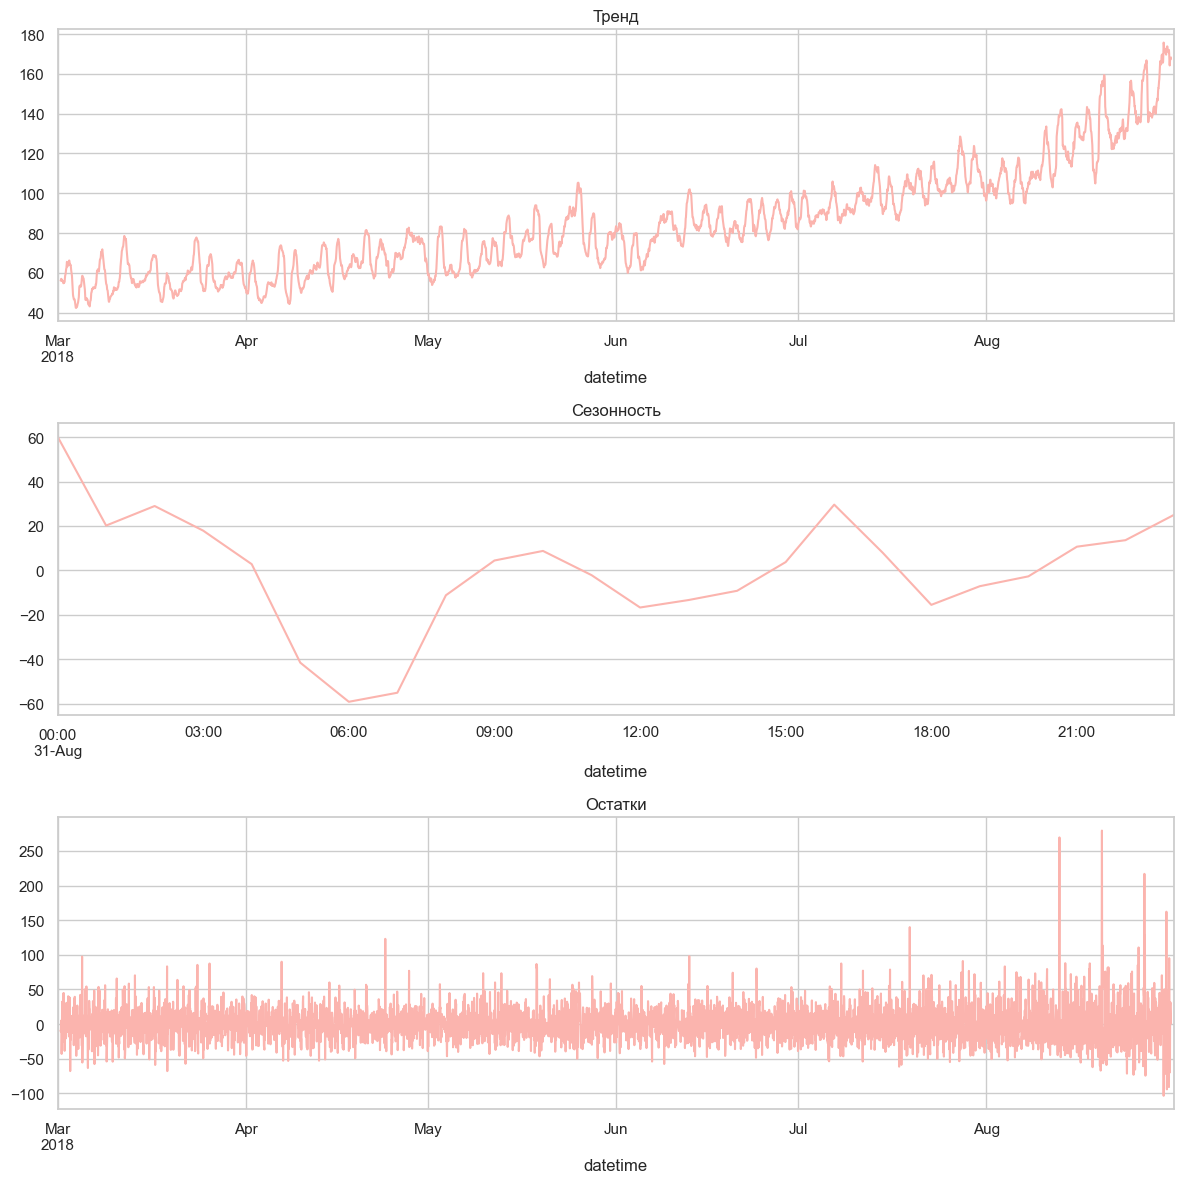

In [21]:
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

#посмотрим на дневную сезонность
decomposed.seasonal.tail(24).plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

### Проведем стат тест **Dickey-Fuller** (Дики-Фуллера) на стационарность ряда и визуализируем наши данные в автокорреляции по часам

**Сформулируем гипотезы:**

- **H0:** Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

- **H1:** Временной ряд является стационарным.

- Установим **α = 0.01 (1%)**



Критерий Дики-Фуллера: p=0.028940
H0 подтвердилась, временной ряд имеет единичные корни, ряд не стационарен


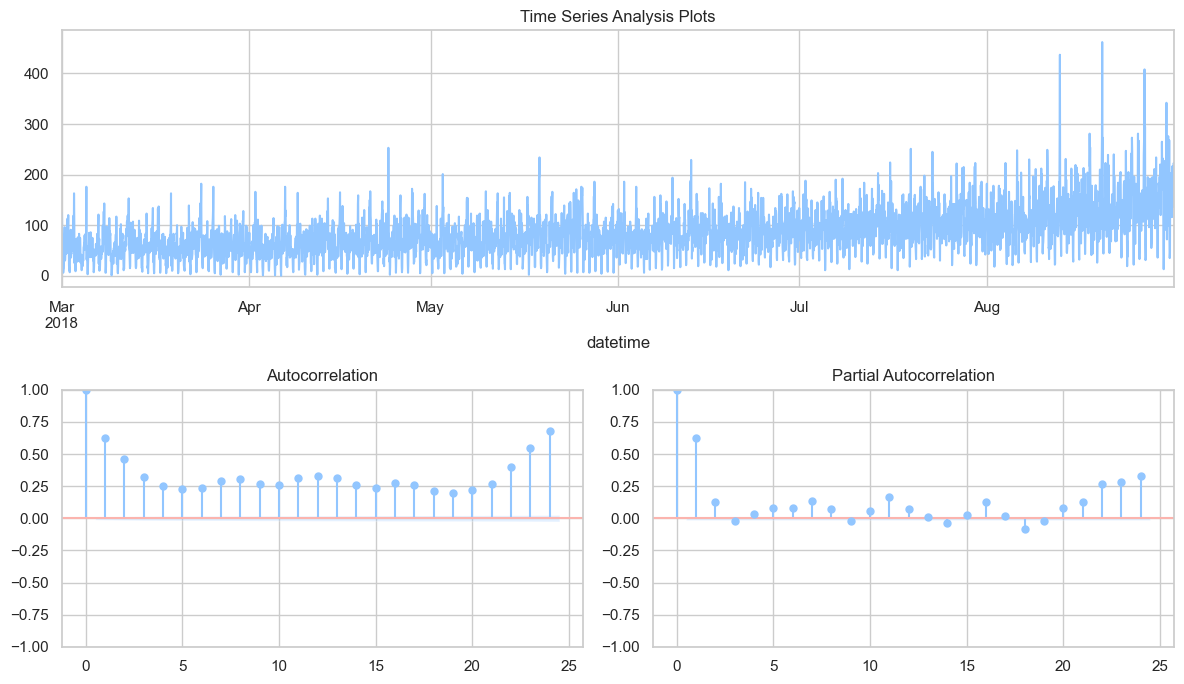

In [22]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context("seaborn-pastel"):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        α = 0.01

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        if sm.tsa.stattools.adfuller(y)[1] > 0.01:
            print("H0 подтвердилась, временной ряд имеет единичные корни, ряд не стационарен")
        else:
            print("отвергаем H0, временной ряд не имеет единичных корней , ряд стационарен") 

        plt.tight_layout()
    return 

tsplot(taxi['num_orders'], lags=24)

Как мы можем наблюдать, при установке значимости **α = 0.01 (1%)** у нас ряд **не стационарен**, однако, если установить уровень значимости **α = 0.05 (5%)** ряд будет **стационарным**.

Но так как мы всегда полагаемся на данные и наши исследования (мы наблюдаем рост заказов в тренде, причем зависимость не линейная а скорее квадратичная, плюс наблюдается наличие сезонности, отчетливо видна **дневная** сезонность), устанавливаем значение **α** строже, так как понимая нашу задачу прогнозирования заказов, этот фактор имеет очень важную составляющую. Прогнозировать на нестационарном ряду сложнее, чем на стационарном. Иначе говоря, нам предстоит строить прогнозирование сравнивая исходный датасет. 

По графику автокорреляции можем наблюдать пики начиная с **00:00 часов и заканчивая 3 часами ночи**, далее **с 22 часов и до 00:00** так же.


In [23]:
taxi.shape[0]

4416

### Создадим признаки с помощью Prophet

In [24]:
predictions = 24*4

train_df = taxi[:-predictions]
train_df.reset_index(inplace=True)
train_df.columns = ['ds', 'y']
taxi.columns = ['y']
train_df.tail()

# Python
m = Prophet(changepoint_prior_scale=0.10, seasonality_prior_scale=10.00, holidays_prior_scale=0.01,
            seasonality_mode= 'additive')
m.fit(train_df);

future = m.make_future_dataframe(periods=predictions, freq='1H')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing


ds   yhat  yhat_lower  yhat_upper
4411 2018-08-31 19:00:00 141.85      105.42      176.01
4412 2018-08-31 20:00:00 148.66      113.59      182.96
4413 2018-08-31 21:00:00 163.98      132.74      199.98
4414 2018-08-31 22:00:00 177.79      143.32      210.08
4415 2018-08-31 23:00:00 185.04      153.31      218.91

In [25]:
forecast.shape[0]

4416

In [26]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


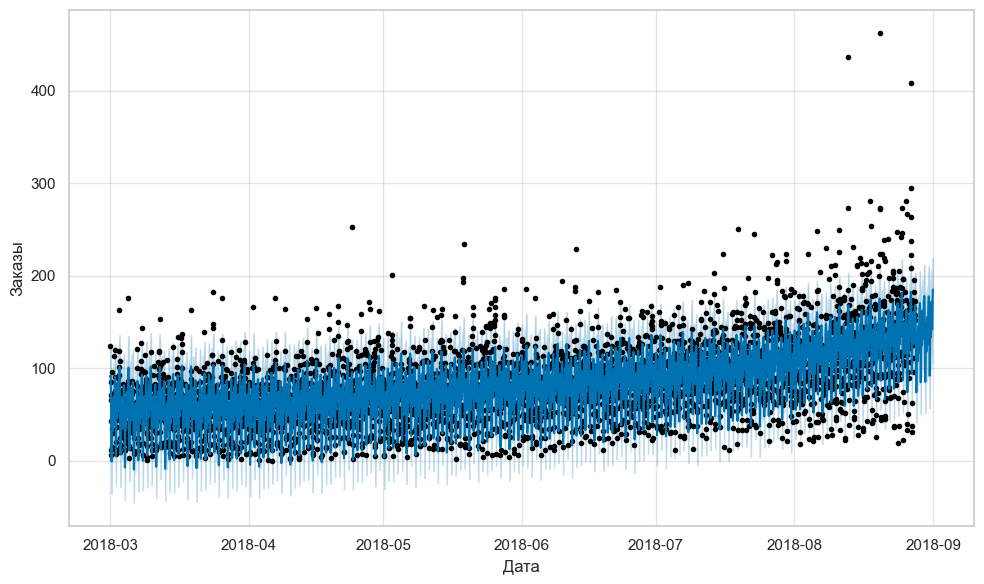

In [27]:
m.plot(forecast)
plt.xlabel('Дата')
plt.ylabel('Заказы');

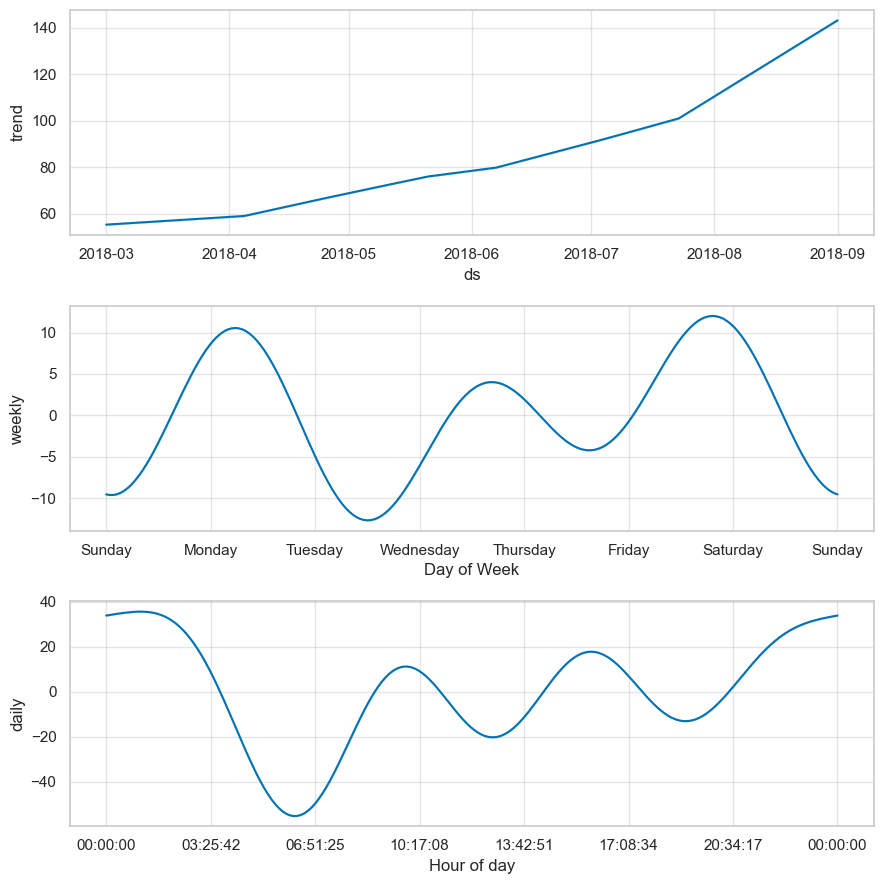

In [28]:
m.plot_components(forecast);

**Посмотрим на интерактивный график прогноза заказов**

In [29]:
cmp_df = forecast.set_index('ds')[['yhat', 'trend','additive_terms', 'yhat_lower', 'yhat_upper', 'trend_lower',
                                   'trend_upper',  'additive_terms', 'additive_terms_lower',
                                   'additive_terms_upper', 'daily', 'weekly']].join(taxi)

In [30]:
#функция для визуализации построенного прогноза
def show_forecast(df, num_predictions, num_values):
    #верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    #прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=df.tail(predictions).index,
        y=df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    #нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_lower,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines')

    #фактические значения
    fact = go.Scatter(
        name='Fact',
        x=df.tail(num_values).index,
        y=df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    #последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Количество заказов'),
        title='Заказы такси: прогноз',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(round(cmp_df), predictions, 200)
plt.show('svg')

**Мы можем наблюдать что переломные пики предсказать очень трудно**

In [31]:
cmp_df.isna().sum()

yhat                    0
trend                   0
additive_terms          0
yhat_lower              0
yhat_upper              0
trend_lower             0
trend_upper             0
additive_terms          0
additive_terms_lower    0
additive_terms_upper    0
daily                   0
weekly                  0
y                       0
dtype: int64

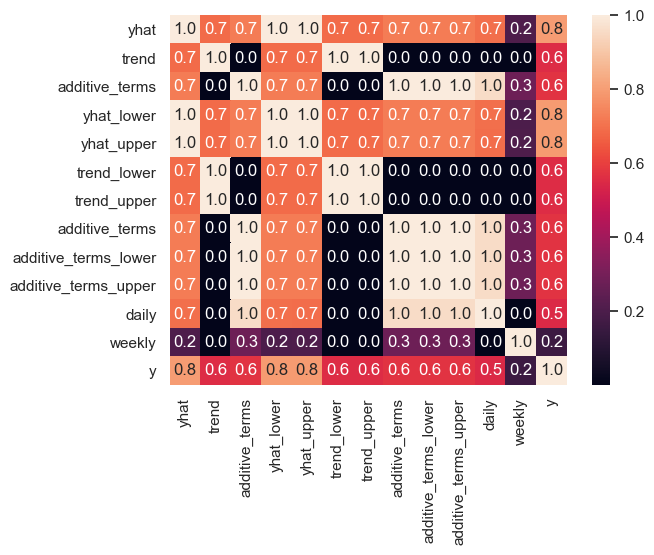

In [32]:
sns.heatmap(data=cmp_df.corr(), annot=True, fmt='.1f');

# Обучение

In [33]:
train, test = train_test_split(cmp_df, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()
test = test.dropna()
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)
y_train = train['y']
y_test = test['y']
print(f"  Train: size={train.shape[0]}")
print(f"  Test:  size={test.shape[0]}")

  Train: size=3974
  Test:  size=442


In [34]:
X_train

yhat  trend  additive_terms  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  daily  weekly
ds                                                                                                                                                                            
2018-03-01 00:00:00  91.07  55.22           35.85       58.90      126.13        55.22        55.22           35.85                 35.85                 35.85  33.91    1.94
2018-03-01 01:00:00  92.26  55.22           37.04       58.19      123.83        55.22        55.22           37.04                 37.04                 37.04  35.61    1.43
2018-03-01 02:00:00  89.06  55.23           33.84       54.64      122.13        55.23        55.23           33.84                 33.84                 33.84  32.95    0.89
2018-03-01 03:00:00  74.58  55.23           19.35       40.51      107.77        55.23        55.23           19.35                 19.35                 19.35  19.02    0.33
2018-03-01 04:00:00  47.02  55.24           -8.22       15.59       80.09        55.24        55.24           -8.22                 -8.22                 -8.22  -7.98   -0.24
2018-03-01 05:00:00  16.22  55.24          -39.02      -20.93       49.10        55.24        55.24          -39.02                -39.02                -39.02 -38.21   -0.81
2018-03-01 06:00:00  -0.89  55.25          -56.14      -35.87       35.31        55.25        55.25          -56.14                -56.14                -56.14 -54.78   -1.36
2018-03-01 07:00:00   6.21  55.25          -49.04      -26.33       41.01        55.25        55.25          -49.04                -49.04                -49.04 -47.15   -1.89
2018-03-01 08:00:00  31.56  55.25          -23.70       -0.70       65.11        55.25        55.25          -23.70                -23.70                -23.70 -21.31   -2.39
2018-03-01 09:00:00  56.11  55.26            0.85       23.19       88.71        55.26        55.26            0.85                  0.85                  0.85   3.69   -2.84
2018-03-01 10:00:00  62.98  55.26            7.72       25.27       95.79        55.26        55.26            7.72                  7.72                  7.72  10.96   -3.24
2018-03-01 11:00:00  51.15  55.27           -4.11       16.83       86.62        55.27        55.27           -4.11                 -4.11                 -4.11  -0.53   -3.59
2018-03-01 12:00:00  35.27  55.27          -20.00        2.48       69.53        55.27        55.27          -20.00                -20.00                -20.00 -16.14   -3.86
2018-03-01 13:00:00  31.87  55.28          -23.40       -1.51       63.74        55.28        55.28          -23.40                -23.40                -23.40 -19.34   -4.07
2018-03-01 14:00:00  44.63  55.28          -10.65        8.99       79.21        55.28        55.28          -10.65                -10.65                -10.65  -6.46   -4.19
2018-03-01 15:00:00  62.04  55.28            6.76       25.24       95.59        55.28        55.28            6.76                  6.76                  6.76  10.99   -4.23
2018-03-01 16:00:00  68.89  55.29           13.60       35.33      104.25        55.29        55.29           13.60                 13.60                 13.60  17.79   -4.19
2018-03-01 17:00:00  60.35  55.29            5.06       29.18       94.61        55.29        55.29            5.06                  5.06                  5.06   9.11   -4.06
2018-03-01 18:00:00  45.63  55.30           -9.67       11.79       81.95        55.30        55.30           -9.67                 -9.67                 -9.67  -5.83   -3.84
2018-03-01 19:00:00  38.72  55.30          -16.58        2.20       70.96        55.30        55.30          -16.58                -16.58                -16.58 -13.05   -3.53
2018-03-01 20:00:00  45.90  55.31           -9.40       10.86       79.99        55.31        55.31           -9.40                 -9.40                 -9.40  -6.27   -3.

In [35]:
X_test

yhat  trend  additive_terms  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  daily  weekly
ds                                                                                                                                                                            
2018-08-13 14:00:00 123.62 123.67           -0.04       91.38      159.65       123.67       123.67           -0.04                 -0.04                 -0.04  -6.46    6.41
2018-08-13 15:00:00 140.14 123.71           16.43      106.14      172.81       123.71       123.71           16.43                 16.43                 16.43  10.99    5.44
2018-08-13 16:00:00 145.95 123.75           22.19      111.13      179.79       123.75       123.75           22.19                 22.19                 22.19  17.79    4.41
2018-08-13 17:00:00 136.22 123.80           12.42      102.67      173.79       123.80       123.80           12.42                 12.42                 12.42   9.11    3.31
2018-08-13 18:00:00 120.18 123.84           -3.66       88.28      155.64       123.84       123.84           -3.66                 -3.66                 -3.66  -5.83    2.17
2018-08-13 19:00:00 111.83 123.89          -12.06       76.90      145.30       123.89       123.89          -12.06                -12.06                -12.06 -13.05    0.99
2018-08-13 20:00:00 117.45 123.93           -6.48       82.82      151.03       123.93       123.93           -6.48                 -6.48                 -6.48  -6.27   -0.21
2018-08-13 21:00:00 131.70 123.97            7.73       98.28      165.69       123.97       123.97            7.73                  7.73                  7.73   9.14   -1.41
2018-08-13 22:00:00 144.56 124.02           20.54      110.74      178.96       124.02       124.02           20.54                 20.54                 20.54  23.15   -2.61
2018-08-13 23:00:00 150.98 124.06           26.92      116.19      182.77       124.06       124.06           26.92                 26.92                 26.92  30.71   -3.80
2018-08-14 00:00:00 153.06 124.11           28.96      119.01      189.54       124.11       124.11           28.96                 28.96                 28.96  33.91   -4.95
2018-08-14 01:00:00 153.70 124.15           29.55      120.81      188.19       124.15       124.15           29.55                 29.55                 29.55  35.61   -6.06
2018-08-14 02:00:00 150.03 124.19           25.84      117.30      183.77       124.19       124.19           25.84                 25.84                 25.84  32.95   -7.11
2018-08-14 03:00:00 135.16 124.24           10.92      100.80      168.60       124.24       124.24           10.92                 10.92                 10.92  19.02   -8.10
2018-08-14 04:00:00 107.29 124.28          -16.99       71.94      140.67       124.28       124.28          -16.99                -16.99                -16.99  -7.98   -9.01
2018-08-14 05:00:00  76.28 124.33          -48.05       39.16      110.15       124.33       124.33          -48.05                -48.05                -48.05 -38.21   -9.84
2018-08-14 06:00:00  59.02 124.37          -65.35       24.35       93.49       124.37       124.37          -65.35                -65.35                -65.35 -54.78  -10.57
2018-08-14 07:00:00  66.06 124.41          -58.35       32.11       98.45       124.41       124.41          -58.35                -58.35                -58.35 -47.15  -11.20
2018-08-14 08:00:00  91.42 124.46          -33.04       55.91      124.24       124.46       124.46          -33.04                -33.04                -33.04 -21.31  -11.73
2018-08-14 09:00:00 116.05 124.50           -8.45       80.74      148.98       124.50       124.50           -8.45                 -8.45                 -8.45   3.69  -12.14
2018-08-14 10:00:00 123.07 124.55           -1.48       86.73      157.92       124.55       124.55           -1.48                 -1.48                 -1.48  10.96  -12.

In [36]:
pipeline = Pipeline(steps=[('scaler', RobustScaler())])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [37]:
split = TimeSeriesSplit(n_splits=3)

In [38]:
#функция для кросс валидации (подбора модели без гиперпараметров)
def cross_val(model):
    cvs = cross_val_score(model, X_train, y_train, cv=split,
                          scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return print("Лучшее значение",  model,  "на кросс валидации:", -cvs)

In [39]:
cross_val(Lasso(random_state=RANDOM_STATE))

Лучшее значение Lasso(random_state=42) на кросс валидации: 27.016439129307056


In [40]:
cross_val(ElasticNet(random_state=RANDOM_STATE))

Лучшее значение ElasticNet(random_state=42) на кросс валидации: 28.898829099660322


In [41]:
cross_val(Ridge(random_state=RANDOM_STATE))

Лучшее значение Ridge(random_state=42) на кросс валидации: 25.895094299209052


In [42]:
cross_val(LGBMRegressor(random_state=RANDOM_STATE))

Лучшее значение LGBMRegressor(random_state=42) на кросс валидации: 25.516545275149635


In [43]:
cross_val(CatBoostRegressor(random_state=RANDOM_STATE))

Лучшее значение <catboost.core.CatBoostRegressor object at 0x000001DB75AC9130> на кросс валидации: 25.431942609803155


**По итогам кросс валидации у нас лидируют Ridge, LGBM и CatBoost**

In [44]:
%%time
rg = Pipeline(steps=[('regressor', Ridge(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1]
}

#создаем объект GridSearchCV
s_rg = GridSearchCV(rg, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_rg.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_rg.best_params_)
print("Лучшее значение: ", -s_rg.best_score_)

Лучшие параметры:  {'regressor__alpha': 0.001}
Лучшее значение:  25.860166927634083
CPU times: total: 31.2 ms
Wall time: 47.2 ms


In [45]:
%%time
lgbm = Pipeline(steps=[('regressor', LGBMRegressor(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__n_estimators' : range(100, 400, 50),
    'regressor__max_depth' : range(10, 16 , 5),
}

#создаем объект GridSearchCV
s_lgbm = GridSearchCV(lgbm, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_lgbm.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_lgbm.best_params_)
print("Лучшее значение: ", -s_lgbm.best_score_)

Лучшие параметры:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 15, 'regressor__n_estimators': 100}
Лучшее значение:  25.594133057005692
CPU times: total: 1.5 s
Wall time: 8.13 s


In [46]:
%%time
cb = Pipeline(steps=[('regressor', CatBoostRegressor(random_state=RANDOM_STATE))])
param_grid = {
    'regressor__learning_rate': [0.1, 0.3, 0.01],
    'regressor__n_estimators': range(100, 301, 100),
}

#создаем объект GridSearchCV
s_cb = GridSearchCV(cb, param_grid=param_grid, cv=split,
                    scoring='neg_root_mean_squared_error', refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_cb.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_cb.best_params_)
print("Лучшее значение: ", -s_cb.best_score_)

0:	learn: 36.5804327	total: 175ms	remaining: 34.8s
1:	learn: 34.8490365	total: 183ms	remaining: 18.1s
2:	learn: 33.2043753	total: 190ms	remaining: 12.5s
3:	learn: 31.8352897	total: 195ms	remaining: 9.58s
4:	learn: 30.6889742	total: 200ms	remaining: 7.8s
5:	learn: 29.6247630	total: 204ms	remaining: 6.6s
6:	learn: 28.7895990	total: 207ms	remaining: 5.72s
7:	learn: 28.0260796	total: 211ms	remaining: 5.06s
8:	learn: 27.3878357	total: 214ms	remaining: 4.54s
9:	learn: 26.8260877	total: 217ms	remaining: 4.11s
10:	learn: 26.3724179	total: 219ms	remaining: 3.77s
11:	learn: 25.9986757	total: 222ms	remaining: 3.48s
12:	learn: 25.5942685	total: 225ms	remaining: 3.23s
13:	learn: 25.2046812	total: 227ms	remaining: 3.01s
14:	learn: 24.8602893	total: 229ms	remaining: 2.82s
15:	learn: 24.5611327	total: 231ms	remaining: 2.66s
16:	learn: 24.3638737	total: 234ms	remaining: 2.52s
17:	learn: 24.1990687	total: 237ms	remaining: 2.39s
18:	learn: 24.0572313	total: 239ms	remaining: 2.28s
19:	learn: 23.9407879	to

198:	learn: 17.5876912	total: 772ms	remaining: 3.88ms
199:	learn: 17.5582389	total: 775ms	remaining: 0us
Лучшие параметры:  {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Лучшее значение:  25.14833858644414
CPU times: total: 3.94 s
Wall time: 11.2 s


**Так как все три модели показывают впринципе неплохой результат, я склоняюсь сделать bagging для двух моделей-Ridge(линейная) так как мы знаем, что линейные модели хорошо экстраполируют, чтобы строить прогноз не только на ближайший час, а видеть тренды, по месяцам..., и CatBoost так как у этой модели вшиты хорошие параметры для предотвращения переобучения**

In [47]:
#создаем базовые модели
catboost = s_cb.best_estimator_
ridge = s_rg.best_estimator_

#создаем бэггинг-модель, используя базовые модели
bagging = BaggingRegressor(base_estimator=catboost, n_estimators=6, random_state=RANDOM_STATE)

pipeline = Pipeline([('bagging', bagging)
])


param_grid = { }

#создаем объект GridSearchCV
search_bagging = GridSearchCV(pipeline, param_grid=param_grid, cv=split,
                              scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

#обучаем модель на тренировочных данных
search_bagging.fit(X_train, y_train)

#выводим результаты кросс-валидации
print("Best cross-validation score: ", -search_bagging.best_score_)


0:	learn: 36.7191470	total: 4.61ms	remaining: 917ms
1:	learn: 34.8782933	total: 9.13ms	remaining: 904ms
2:	learn: 33.2422153	total: 12.6ms	remaining: 827ms
3:	learn: 31.8904818	total: 16ms	remaining: 782ms
4:	learn: 30.6614022	total: 20ms	remaining: 779ms
5:	learn: 29.5894539	total: 24.7ms	remaining: 799ms
6:	learn: 28.6630445	total: 28.2ms	remaining: 776ms
7:	learn: 27.8971493	total: 31.5ms	remaining: 756ms
8:	learn: 27.1843902	total: 35.3ms	remaining: 750ms
9:	learn: 26.5899465	total: 40.2ms	remaining: 763ms
10:	learn: 26.0968517	total: 43.5ms	remaining: 748ms
11:	learn: 25.6029332	total: 46.9ms	remaining: 734ms
12:	learn: 25.1516768	total: 50.4ms	remaining: 725ms
13:	learn: 24.8333924	total: 55.2ms	remaining: 733ms
14:	learn: 24.5283017	total: 58.7ms	remaining: 724ms
15:	learn: 24.2784867	total: 62.2ms	remaining: 715ms
16:	learn: 24.0533904	total: 65.7ms	remaining: 707ms
17:	learn: 23.8363972	total: 70.1ms	remaining: 709ms
18:	learn: 23.6044894	total: 73.6ms	remaining: 701ms
19:	lea

168:	learn: 16.6571666	total: 593ms	remaining: 109ms
169:	learn: 16.6363341	total: 597ms	remaining: 105ms
170:	learn: 16.6133345	total: 601ms	remaining: 102ms
171:	learn: 16.5940926	total: 604ms	remaining: 98.3ms
172:	learn: 16.5794254	total: 607ms	remaining: 94.8ms
173:	learn: 16.5521091	total: 610ms	remaining: 91.2ms
174:	learn: 16.5332152	total: 614ms	remaining: 87.7ms
175:	learn: 16.5208894	total: 617ms	remaining: 84.1ms
176:	learn: 16.4949984	total: 620ms	remaining: 80.6ms
177:	learn: 16.4634363	total: 624ms	remaining: 77.1ms
178:	learn: 16.4316217	total: 628ms	remaining: 73.7ms
179:	learn: 16.4182310	total: 631ms	remaining: 70.1ms
180:	learn: 16.3927074	total: 634ms	remaining: 66.6ms
181:	learn: 16.3687504	total: 638ms	remaining: 63.1ms
182:	learn: 16.3490189	total: 641ms	remaining: 59.6ms
183:	learn: 16.3204723	total: 644ms	remaining: 56ms
184:	learn: 16.2918686	total: 647ms	remaining: 52.5ms
185:	learn: 16.2711526	total: 651ms	remaining: 49ms
186:	learn: 16.2417151	total: 654ms

140:	learn: 18.1111599	total: 463ms	remaining: 194ms
141:	learn: 18.0842868	total: 467ms	remaining: 191ms
142:	learn: 18.0492010	total: 471ms	remaining: 188ms
143:	learn: 18.0336370	total: 476ms	remaining: 185ms
144:	learn: 17.9919802	total: 479ms	remaining: 182ms
145:	learn: 17.9652919	total: 483ms	remaining: 179ms
146:	learn: 17.9294579	total: 487ms	remaining: 176ms
147:	learn: 17.8943003	total: 491ms	remaining: 173ms
148:	learn: 17.8644536	total: 496ms	remaining: 170ms
149:	learn: 17.8472375	total: 500ms	remaining: 167ms
150:	learn: 17.8266064	total: 505ms	remaining: 164ms
151:	learn: 17.7882818	total: 509ms	remaining: 161ms
152:	learn: 17.7661675	total: 515ms	remaining: 158ms
153:	learn: 17.7429604	total: 520ms	remaining: 155ms
154:	learn: 17.7137909	total: 524ms	remaining: 152ms
155:	learn: 17.6939698	total: 527ms	remaining: 149ms
156:	learn: 17.6684500	total: 531ms	remaining: 145ms
157:	learn: 17.6573861	total: 536ms	remaining: 143ms
158:	learn: 17.6404574	total: 540ms	remaining:

150:	learn: 17.6404383	total: 517ms	remaining: 168ms
151:	learn: 17.6069786	total: 521ms	remaining: 164ms
152:	learn: 17.5830032	total: 524ms	remaining: 161ms
153:	learn: 17.5417420	total: 527ms	remaining: 157ms
154:	learn: 17.5254137	total: 530ms	remaining: 154ms
155:	learn: 17.5040810	total: 533ms	remaining: 150ms
156:	learn: 17.4781879	total: 536ms	remaining: 147ms
157:	learn: 17.4529423	total: 539ms	remaining: 143ms
158:	learn: 17.4136772	total: 542ms	remaining: 140ms
159:	learn: 17.3859993	total: 545ms	remaining: 136ms
160:	learn: 17.3649169	total: 549ms	remaining: 133ms
161:	learn: 17.3424613	total: 552ms	remaining: 129ms
162:	learn: 17.3295890	total: 554ms	remaining: 126ms
163:	learn: 17.2964243	total: 558ms	remaining: 122ms
164:	learn: 17.2778276	total: 561ms	remaining: 119ms
165:	learn: 17.2397908	total: 564ms	remaining: 115ms
166:	learn: 17.2166583	total: 566ms	remaining: 112ms
167:	learn: 17.1870170	total: 569ms	remaining: 108ms
168:	learn: 17.1694994	total: 573ms	remaining:

135:	learn: 17.4498135	total: 426ms	remaining: 200ms
136:	learn: 17.4034812	total: 429ms	remaining: 197ms
137:	learn: 17.3638734	total: 432ms	remaining: 194ms
138:	learn: 17.3380210	total: 435ms	remaining: 191ms
139:	learn: 17.3110080	total: 439ms	remaining: 188ms
140:	learn: 17.3005371	total: 443ms	remaining: 185ms
141:	learn: 17.2483809	total: 446ms	remaining: 182ms
142:	learn: 17.1931540	total: 449ms	remaining: 179ms
143:	learn: 17.1830979	total: 452ms	remaining: 176ms
144:	learn: 17.1544162	total: 456ms	remaining: 173ms
145:	learn: 17.1329708	total: 460ms	remaining: 170ms
146:	learn: 17.1104487	total: 463ms	remaining: 167ms
147:	learn: 17.0930925	total: 466ms	remaining: 164ms
148:	learn: 17.0624443	total: 469ms	remaining: 161ms
149:	learn: 17.0468820	total: 473ms	remaining: 158ms
150:	learn: 17.0250000	total: 476ms	remaining: 155ms
151:	learn: 17.0083238	total: 479ms	remaining: 151ms
152:	learn: 16.9936935	total: 482ms	remaining: 148ms
153:	learn: 16.9762405	total: 486ms	remaining:

132:	learn: 18.4348790	total: 372ms	remaining: 187ms
133:	learn: 18.3989105	total: 375ms	remaining: 185ms
134:	learn: 18.3849961	total: 378ms	remaining: 182ms
135:	learn: 18.3362502	total: 381ms	remaining: 179ms
136:	learn: 18.3249113	total: 384ms	remaining: 177ms
137:	learn: 18.2992471	total: 387ms	remaining: 174ms
138:	learn: 18.2750171	total: 390ms	remaining: 171ms
139:	learn: 18.2555526	total: 393ms	remaining: 168ms
140:	learn: 18.2160131	total: 396ms	remaining: 166ms
141:	learn: 18.2035343	total: 399ms	remaining: 163ms
142:	learn: 18.1604147	total: 402ms	remaining: 160ms
143:	learn: 18.1441665	total: 404ms	remaining: 157ms
144:	learn: 18.1086990	total: 407ms	remaining: 154ms
145:	learn: 18.0671122	total: 410ms	remaining: 152ms
146:	learn: 18.0331478	total: 412ms	remaining: 149ms
147:	learn: 17.9821222	total: 415ms	remaining: 146ms
148:	learn: 17.9708470	total: 418ms	remaining: 143ms
149:	learn: 17.9431864	total: 421ms	remaining: 140ms
150:	learn: 17.9327020	total: 423ms	remaining:

140:	learn: 17.3886734	total: 389ms	remaining: 163ms
141:	learn: 17.3719288	total: 392ms	remaining: 160ms
142:	learn: 17.3488992	total: 395ms	remaining: 157ms
143:	learn: 17.3223860	total: 398ms	remaining: 155ms
144:	learn: 17.3031498	total: 401ms	remaining: 152ms
145:	learn: 17.2699017	total: 403ms	remaining: 149ms
146:	learn: 17.2228962	total: 407ms	remaining: 147ms
147:	learn: 17.1905148	total: 409ms	remaining: 144ms
148:	learn: 17.1568787	total: 412ms	remaining: 141ms
149:	learn: 17.1173301	total: 415ms	remaining: 138ms
150:	learn: 17.0977689	total: 418ms	remaining: 136ms
151:	learn: 17.0600703	total: 421ms	remaining: 133ms
152:	learn: 17.0324479	total: 424ms	remaining: 130ms
153:	learn: 17.0132442	total: 427ms	remaining: 127ms
154:	learn: 17.0005256	total: 429ms	remaining: 125ms
155:	learn: 16.9832511	total: 432ms	remaining: 122ms
156:	learn: 16.9661325	total: 435ms	remaining: 119ms
157:	learn: 16.9330643	total: 438ms	remaining: 116ms
158:	learn: 16.8988157	total: 441ms	remaining:

# Тестирование

**Константная модель**

In [48]:
dummy = Pipeline(steps=[('regressor',DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

test_model = dummy.predict(X_test)

RMSE = mean_squared_error(y_test, test_model, squared=False)

print('RMSE DummyRegressor равен:', round(RMSE, 2))


RMSE DummyRegressor равен: 84.74


In [49]:
%%time
bg = search_bagging.best_estimator_.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test, bg))
print('RMSE Bagging тест равен:', round(RMSE, 2))

RMSE Bagging тест равен: 36.51
CPU times: total: 15.6 ms
Wall time: 16.8 ms


**Интерактивный график предсказания лучшей модели и факта**

In [50]:
x = y_test.values
y = bg.astype(int)
data = pd.DataFrame({'true': x, 'predict': y}).set_index(y_test.index)
plotly_df(data, title='Сравнение предсказания и факта')
plt.show('svg')

# Вывод:

Модель победитель **CatBoost & Ridge** (**Bagging Regressor**) 
- **RMSE обучающей выборки: 25.05**
- **RMSE тестовой выборки: 36.51**

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48